# Lasso Via Bounded Coordinate Descent

This is an implementation of coordinate descent with bounded coefficients.

# Known Issues
1. It is pretty close to the sklearn implementation in terms of the resulting coefficients but there are issues as lambda increases – see the comparison with sklearn section of this notebook.  The coefficients approach zero in a comparable manner but do not match properly, sometimes with discrepancies in the order of 0.1.  I suspect this is an issue with the scale of lambda.  I.e. I think the coefficient paths are the same as for `sklearn` but the scaling of `lambda` does not match between the two implementations, so comparing each model with the same value of `lambda` (`alpha`) gives different amounts of regularisation.  (See the second useful resource link for some code to plot the coefficient paths which could be used to confirm this.)
2. The implementation can be greatly improved and simplified.  E.g. I've included some logic to determine a range of lambdas to train on, which should be dropped.  Also, I think it would be better to handle adding the intercept inside the model class, rather than as an external step.
3. OOP could be used to improve the structure of the CLasso class.
4. The `__repr__` is pretty rubbish.

## Some Useful Resources
[This page](https://xavierbourretsicotte.github.io/lasso_derivation.html) has been useful in understanding the maths behind coordinate descent.  It is based on [this page](https://web.archive.org/web/20180724021415/http://jocelynchi.com/soft-thresholding-operator-and-the-lasso-solution).

[This page](https://xavierbourretsicotte.github.io/lasso_implementation.html) is the implementation I've used below (with some modifications).

[This Coursera video](https://www.coursera.org/lecture/ml-regression/deriving-the-lasso-coordinate-descent-update-6OLyn) is also useful in understanding the maths.

In [1]:
from __future__ import annotations
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
def rmse(true, pred):

    return np.sqrt(mean_squared_error(true, pred))

In [3]:
data = datasets.fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)

In [4]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [5]:
X = pd.DataFrame(X, columns=data.feature_names)
X['intercept'] = 1
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,intercept
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,1
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1


In [6]:
features = X.columns

In [7]:
class Bounds:
    
    def __init__(self, lower=-np.inf, upper=np.inf) -> None:
        
        self.lower = lower
        self.upper = upper
        
        self._check_bounds()
        
    def _check_bounds(self) -> None:
        '''Make sure lower is less than upper.
        '''
        
        if self.lower >= self.upper:
            err_msg = f'Lower bound ({self.lower}) should be less than upper bound ({self.upper}).'
            raise ValueError(err_msg)
            
            
    def __repr__(self):
        
        return f'{self.__class__.__name__}, lower: {self.lower}, upper: {self.upper}'

# A Few Notes on the Maths

The useful resources give the full picture.  The following is a very quick rundown.

Recall this is the Lasso objective function in Lagrangian form:
$$
\min\limits_{\beta} \|y-X\beta\|^2 + \lambda \|\beta_p\|_1
$$

We know the first term's analytical solution, as this is simply the OLS term.  The challenge with 
Lasso is that the regularisation term, is not differentiable as the derivative at zero is undefined.

Coordinate descent minimises this objective function by finding the minimum of each 'coordinate' (for each feature) in turn.  Technically the implementation below is cyclic coordinate descent because we just loop over the features repeatedly until some maximum number of iterations.  There are alternatives, such as random coordinate descent where the feature to be used to minimise the objective is selected at random in each loop.

By solving in one coordinate at a time, we can find a solution to the Lasso objective function.  The solution to the OLS portion is given by:
$$
\rho_j = \sum_{i=1}^m x_j^{(i)}  (y^{(i)}  - \sum_{k \neq j}^n \theta_k x_k^{(i)} ) = \sum_{i=1}^m x_j^{(i)}  (y^{(i)}  - \hat y^{(i)}_{pred} + \theta_j x_j^{(i)} )
$$

Where $\theta$ is the coefficients vector, $j$ indexes the current feature, $k$ indexes all of the non-current features and $i$ indexes the sample (row).

This leaves us with the regularisation term, which is a function of the absolute value of the coefficients:

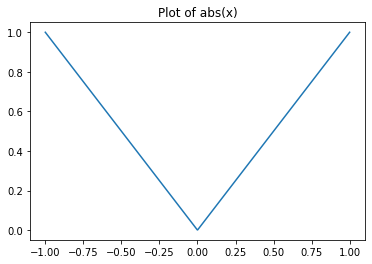

In [8]:
x_plot = np.linspace(-1, 1, 1000)
y_plot = np.abs(x_plot)
plt.plot(x_plot, y_plot)
plt.title('Plot of abs(x)');

The above plot reminds us why the gradient at $|0|$ is undefined.

To overcome this, we use the concepts of subgradients and subdifferentials.  A subdifferential is the set of all gradients which are below the curve being differentiated.  A subgradient is one of those gradients.  (These concepts are derived from first order Taylor approximations, again, see the useful resources for more info.)

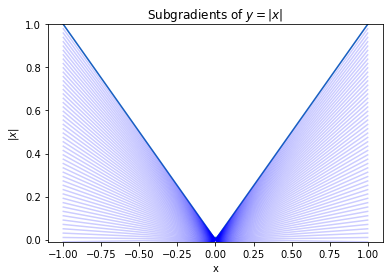

In [9]:
# Lines below the |x| function
x_plot = np.linspace(-1, 1, 100)
y_plot = np.abs(x_plot)
lines = [x_plot[i] * x_plot  for i in range(len(x_plot))]

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot)
[ax.plot(x_plot, lines[i], color='blue', alpha=0.2) for i in range(len(x_plot))]
ax.set_ylim(-0.01, 1)
ax.set_xlabel('x')
ax.set_ylabel('$|x|$')
plt.title('Subgradients of $y = |x|$')
plt.show()

For the region below $x=0$, the gradient of $y = |x|$ is $-1$; above $x=0$, the gradient of $y = |x|$ is $1$.  Since the Lasso regularisation term is multiplied be a scaling factor ($\alpha$ in `sklearn` notation and $\lambda$ in many other places, the gradients above and below $x=0$ are $\lambda$ and $-\lambda$, respectively.

This is where the _soft threshold_ function is derived from: if $\rho$ is more than some small distance (this turns out to be $\lambda / 2$ in the maths but the factor of $\frac{1}{2}$ just scales $\lambda$, so is ommitted below and in the implementation itself) below zero, the regularisation term is $-\lambda$, if $\rho$ is more than some small distance above zero, the regularisation term is $\lambda$.  If $\rho$ is within a small distance of plus or minus zero, the regularisation term is 0.  This can be seen in the following, simplified, version of `_soft_threshold`.

```
def _soft_threshold(ρ, λ):
        '''Soft threshold function for subgradient of Lasso 
        regularisation term.
        '''

        if ρ < -λ:
            return (ρ + λ)
        elif ρ > λ:
            return (ρ - λ)
        else: 
            return 0
```

Note, there is also a normalisation term that arises from the mathematics:
$$
\sum_{i=1}^m (x_j^{(i)})^2
$$

This is the L2 norm of the data for feature $j$.

# Implementation

In [10]:
class CLasso:
    """Constrained Lasso.
    """
    
    def __init__(
        self,
        X: np.array,
        y: np.array,
        features: List[str],
        bounds: Optional[List[Bounds]] = None,
        max_iters=1000,
    ) -> None:
        
        self.X = X
        self.y = y
        self.features = features
        
        self.n_features = len(features)
        self.n_samples = len(X)
        
        # If we don't normalise the data first, we need to apply a 
        # normalisation term in the soft threshold
        self.normalisation_terms = np.sum(np.square(X), axis=0)
        
        # We don't apply any regularisation or bounds to the intercept, so 
        # need one less bounds than features here.
        
        if bounds is None:
            self.bounds = [
                Bounds() for _
                in range(self.n_features)
            ]
        else:
            err_msg = f'Number of bounds, {len(bounds)}, does not match number of non-intercept features {self.n_features - 1}'
            if len(bounds) != self.n_features - 1:
                raise ValueError(err_msg)
            self.bounds = bounds
        
        self.max_iters = max_iters
        
        self.θ = np.ones((self.n_features, 1))
        self.coefs_ = {}
        
        self.lambdas = None
        self.fitted = False
        
        self.ols_coefs = None
        self.l1_norm_ols_coefs = None
        
        self._ols()
        self._l1_norm_ols_coefs()
        
    
    def fit(self, lambdas: Optional[Union[List, np.array]]) -> BoundedLasso:
        '''Wrap around _coordinate_descent_lasso to loop through a 
        range of lambdas.
        '''
        
        if lambdas is None:
            lambdas = self._get_lambdas()

        self.lambdas = lambdas
        for lambda_ in lambdas:
            self._coordinate_descent_lasso(λ=lambda_)
            
        self.fitted = True
        
        return self
    
    
    def predict(self, X: np.array) -> np.array:
        '''Predict for new data for each lambda used to compute a 
        set of coefficients.
        
        Must ensure an intercept column has been appended to the data
        as the last (rightmost) column.
        '''
        
        preds = {}
        for lambda_ in self.lambdas:

            coefs = np.array(list(self.coefs_[lambda_].values()))
            preds[lambda_] = X @ coefs
        
        return preds
        
    
    def _get_lambdas(self) -> np.array:
        '''Generate a list of lambdas to compute coefficients for.
        
        Uses the L1 norm of the OLS solution to compute an upper bound and 
        upper_bound / 1e4 to get the lower bound.
    
        '''
        upper = self.l1_norm_ols_coefs
        lower = self.l1_norm_ols_coefs / 1e4
        num = 10
        
        lambdas = np.logspace(np.log(lower), np.log(upper), num)
        
        return lambdas

    def _ols(self):
        '''Get the OLS solution (without regularisation) to the problem.
        
        Currently, the only use for this is to use the coefficients to set the 
        upper limit for the list of lambdas that is generated if no list is 
        provided.
        '''
        
        ols_coefs, residuals, rank, s = np.linalg.lstsq(self.X, self.y, rcond=None)
        self.ols_coefs = ols_coefs
        
        
    def _l1_norm_ols_coefs(self):
        '''Get the L1 norm of the OLS coefficients.
        Used to set the upper limit of lambda.
        '''
        
        self.l1_norm_ols_coefs = np.linalg.norm(self.ols_coefs, ord=1)
        
    def _coordinate_descent_lasso(self, λ):
        '''Coordinate gradient descent for Lasso regression.
        
        Will always use the maximum allowable number of iterations.
        Provided n_samples > n_features, the problem is convex and so 
        more iterations will just improve precision of the computed 
        coefficients, within the limits of numerical precision.
        '''
        
        for i in range(self.max_iters):
            
            for j in range(self.n_features):
                # Select the feature we are optimising
                X_j = self.X[:, j].reshape(-1, 1)
                
                # Make a prediction with the current thetas
                y_hat = self.X @ self.θ
                
                
                rho = X_j.T @ (self.y - y_hat  + self.θ[j] * X_j)
                
                if self.features[j] == 'intercept':
                    self.θ[j] = rho  / self.normalisation_terms[j]
                else:
                    self.θ[j] =  self._soft_threshold(rho, λ, j)
                    
        self.coefs_[λ] = dict(zip(self.features, self.θ.flatten().tolist()))
        
                
    def _soft_threshold(self, ρ, λ, j):
        '''Soft threshold function for subgradient of Lasso 
        regularisation term.
        
        Requires the data to not be normalised.
        '''
        
        # Scale lambda to be on a range more similar to sklearn's alpha
        # Arbitrarily done here so this should be investigated
        λ *= 2 * self.n_samples
        
        if ρ < self.bounds[j].lower:
            return self.bounds[j].lower
        elif ρ > self.bounds[j].upper:
            return self.bounds[j].upper
        elif ρ < -λ:
            return (ρ + λ) / self.normalisation_terms[j]
        elif ρ > λ:
            return (ρ - λ) / self.normalisation_terms[j]
        else: 
            return 0
        
    def __repr__(self):
        
        fitted = 'Fitted' if self.fitted else 'Unfitted'
        return f'{fitted} {self.__class__.__name__} model with bounds of {self.bounds}'

In [11]:
classo = CLasso(
    X=X.values,
    y=y,
    features=features,
)

In [12]:
lambdas = [1e-8, 1e-6, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1]

In [13]:
# %%timeit

classo.fit(lambdas=lambdas)

Fitted CLasso model with bounds of [Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf, Bounds, lower: -inf, upper: inf]

In [14]:
classo.coefs_

{1e-08: {'MedInc': 0.8296191994360201,
  'HouseAge': 0.11875166936321142,
  'AveRooms': -0.2655266043982511,
  'AveBedrms': 0.3056959555655638,
  'Population': -0.004502974365417709,
  'AveOccup': -0.039326248555480184,
  'Latitude': -0.899885441521409,
  'Longitude': -0.8705407766064438,
  'intercept': 2.068558169089139},
 1e-06: {'MedInc': 0.8296088198373934,
  'HouseAge': 0.11875346631910637,
  'AveRooms': -0.26549936866958845,
  'AveBedrms': 0.3056688059297144,
  'Population': -0.004500306593012022,
  'AveOccup': -0.039324424711287886,
  'Latitude': -0.8998643651048045,
  'Longitude': -0.870518429407106,
  'intercept': 2.068558169089139},
 0.0001: {'MedInc': 0.8285708599746814,
  'HouseAge': 0.11893316190856829,
  'AveRooms': -0.26277579580325444,
  'AveBedrms': 0.3029538423447352,
  'Population': -0.004233529352455765,
  'AveOccup': -0.039142040292055695,
  'Latitude': -0.8977567234446717,
  'Longitude': -0.8682837094736233,
  'intercept': 2.068558169089139},
 0.0005: {'MedInc': 0

In [15]:
preds = classo.predict(X.values)

In [16]:
for lambda_, pred in preds.items():
    print(f'{lambda_:.4f}, {rmse(y, pred)}')

0.0000, 0.7241001216576541
0.0000, 0.724100121812318
0.0001, 0.7241016684486077
0.0005, 0.7241387904406582
0.0010, 0.7242547844022963
0.0050, 0.727859505616037
0.0100, 0.7386696788812306
0.0500, 0.8210612463533518
0.1000, 0.8608897434009495
1.0000, 1.153928204041225


In [17]:
y.mean()

2.068558169089147

In [18]:
lowest_alpha_pred = X.values @ list(classo.coefs_[1e-8].values())

In [19]:
lowest_alpha_pred.mean(), lowest_alpha_pred.std()

(2.0685581690891475, 0.8984593371673665)

# Compare to sklearn

In [20]:
for alpha in classo.coefs_:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X.drop('intercept', axis=1), y)
    lasso_coefs = np.append(lasso.coef_, lasso.intercept_)
    classo_coefs = np.array(list(classo.coefs_[alpha].values()))
    print(alpha)
    print(classo_coefs)
    print(lasso_coefs)
    print(np.abs((classo_coefs - lasso_coefs)).max())
    print()

1e-08
[ 0.8296192   0.11875167 -0.2655266   0.30569596 -0.00450297 -0.03932625
 -0.89988544 -0.87054078  2.06855817]
[ 0.82961925  0.11875166 -0.26552674  0.30569609 -0.00450299 -0.03932626
 -0.89988555 -0.87054089  2.06855817]
1.3978414870052802e-07

1e-06
[ 0.82960882  0.11875347 -0.26549937  0.30566881 -0.00450031 -0.03932442
 -0.89986437 -0.87051843  2.06855817]
[ 0.82961418  0.11875258 -0.26551334  0.30568269 -0.00450165 -0.03932535
 -0.89987474 -0.87052947  2.06855817]
1.3973297946945351e-05

0.0001
[ 0.82857086  0.11893316 -0.2627758   0.30295384 -0.00423353 -0.03914204
 -0.89775672 -0.86828371  2.06855817]
[ 0.82910679  0.11884435 -0.26417261  0.30434164 -0.00436762 -0.03923458
 -0.89879503 -0.86938865  2.06855817]
0.0013968113447884734

0.0005
[ 0.82437708  0.1196592  -0.25177146  0.29198429 -0.00315564 -0.03840513
 -0.889241   -0.85925454  2.06855817]
[ 0.82705039  0.11921412 -0.2587439   0.29891417 -0.00382645 -0.03886759
 -0.89444649 -0.86479188  2.06855817]
0.0069724424267

## Check Runtime

In [21]:
%%timeit

# Single lambda
classo.fit(lambdas=[1e-4])

846 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(f'Training time for {len(lambdas)} values of lambda')

Training time for 10 values of lambda


In [23]:
%%timeit

classo.fit(lambdas=lambdas)

8.97 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
bounds = [
    Bounds(lower=-5, upper=5),
    Bounds(lower=-6, upper=6),
    Bounds(lower=-2, upper=2),
    Bounds(lower=-3, upper=3),
    Bounds(lower=0, upper=2),
    Bounds(lower=-2, upper=0),
    Bounds(lower=-4, upper=4),
    Bounds(lower=-5, upper=5),
]

# Check that Bounds Work

In [25]:
classo2 = CLasso(
    X=X.values,
    y=y,
    features=features,
    bounds=bounds,
)

In [26]:
classo2.fit(lambdas=[1e-8])

Fitted CLasso model with bounds of [Bounds, lower: -5, upper: 5, Bounds, lower: -6, upper: 6, Bounds, lower: -2, upper: 2, Bounds, lower: -3, upper: 3, Bounds, lower: 0, upper: 2, Bounds, lower: -2, upper: 0, Bounds, lower: -4, upper: 4, Bounds, lower: -5, upper: 5]

In [27]:
classo2.coefs_

{1e-08: {'MedInc': 5.0,
  'HouseAge': 6.0,
  'AveRooms': -2.0,
  'AveBedrms': 3.0,
  'Population': 2.0,
  'AveOccup': -2.0,
  'Latitude': 4.0,
  'Longitude': 5.0,
  'intercept': 2.0685581690891937}}

Note, neither regularisation nor bounds are applied to the intercept.